In [142]:
import numpy as np
from matplotlib import pyplot as plt
import os.path as osp
import xarray as xr
import sys
import cartopy.crs as ccrs
import geopandas as gpd
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Polygon, Point
from shapely.ops import cascaded_union

import birds

In [11]:
sys.path

['/home/fiona/birdMigration/notebooks',
 '/home/fiona/anaconda3/lib/python37.zip',
 '/home/fiona/anaconda3/lib/python3.7',
 '/home/fiona/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/home/fiona/.local/lib/python3.7/site-packages',
 '/home/fiona/anaconda3/lib/python3.7/site-packages',
 '/home/fiona/ipyleaflet',
 '/home/fiona/anaconda3/lib/python3.7/site-packages/pykalman-0.9.5-py3.7.egg',
 '/home/fiona/anaconda3/lib/python3.7/site-packages/test_pkg_birdMigration_fionalippert-0.1.0-py3.7.egg',
 '/home/fiona/anaconda3/lib/python3.7/site-packages/birds-0.1.0-py3.7.egg',
 '/home/fiona/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/home/fiona/.ipython']

In [10]:
from birds import abm

ImportError: cannot import name 'abm' from 'birds' (/home/fiona/anaconda3/lib/python3.7/site-packages/birds-0.1.0-py3.7.egg/birds/__init__.py)

In [3]:
root = '/home/fiona/birdMigration/data'
radar_path = osp.join(root, 'raw', 'radar', 'fall', '2015')
radars = datahandling.load_radars(radar_path)
sp = spatial.Spatial(radars)

NameError: name 'datahandling' is not defined

In [145]:
d = '/home/fiona/birdMigration/data/shapes'
countries = gpd.read_file(osp.join(d, 'ne_10m_admin_0_countries_lakes.shp'))
departure_area = gpd.read_file(osp.join(d, 'departure_area.shp'))

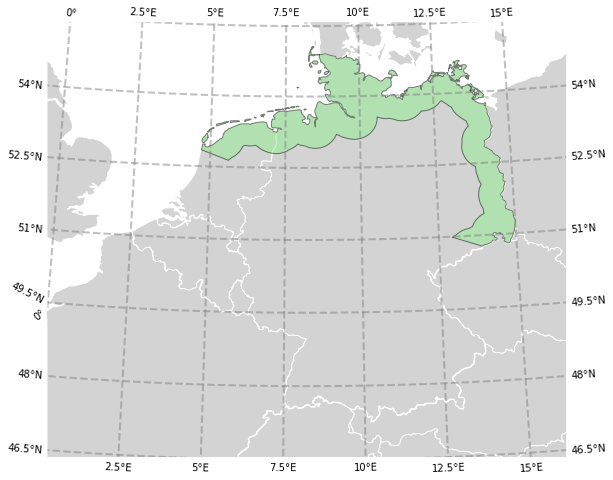

In [146]:
ax = gplt.polyplot(
  countries,
  edgecolor="white",
  facecolor="lightgray",
  figsize=(12, 8),
  projection=gcrs.AlbersEqualArea(),
  extent=[0.36, 46.36, 16.07, 55.40]
)
gplt.polyplot(
    departure_area, 
    facecolor="lightgreen",
    alpha=0.5,
    ax=ax, zorder=1,
    extent=[0.36, 46.36, 16.07, 55.40]
)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

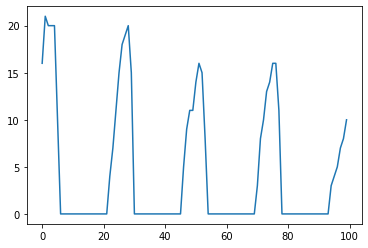

In [20]:
plt.plot(counts.reshape((counts.shape[0], -1)).sum(1))

In [154]:
l=[np.array([3,4]), np.array([5,6,7]), np.array([0])]
max(l)

ValueError: operands could not be broadcast together with shapes (3,) (2,) 